<a href="https://colab.research.google.com/github/HaeRin-OortCloud/AI-Lab/blob/main/Colaboratory%EC%97%90_%EC%98%A4%EC%8B%A0_%EA%B2%83%EC%9D%84_%ED%99%98%EC%98%81%ED%95%A9%EB%8B%88%EB%8B%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Module Import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# Device Check
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

BATCH_SIZE = 32
EPOCHS = 10

Using PyTorch version: 1.13.0+cu116  Device: cpu


In [7]:
# FashionMNIST Data Download
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                     train = False,
                                     transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [8]:
# Data Check(1)
for (x_train, y_train) in train_loader:
  print('x_train:', x_train.size(), 'type:', x_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


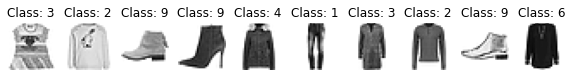

In [11]:
# Data Check(2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(x_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
  plt.title('Class: ' + str(y_train[i].item()))

In [13]:
# AutoEncoder(AE) Model
class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32),
    )

    self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 28 * 28), 
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [14]:
# Optimizer, Objective Function
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [15]:
# Train Model +  Performance Check
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, _) in enumerate(train_loader):
    image = image.view(-1, 28 * 28).to(DEVICE)
    target = image.view(-1, 28 * 28).to(DEVICE)
    optimizer.zero_grad()
    encoded, decoded = model(image)
    loss = criterion(decoded, target)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()
      ))

In [18]:
# Test Model + Performance Check
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  real_image = []
  gen_image = []
  with torch.no_grad():
    for image, _ in test_loader:
      image = image.view(-1, 28 * 28).to(DEVICE)
      target = image.view(-1, 28 * 28).to(DEVICE)
      encoded, decoded = model(image)

      test_loss += criterion(decoded, image).item()
      real_image.append(image.to("cpu"))
      gen_image.append(decoded.to("cpu"))

  test_loss /= len(test_loader.dataset)

  return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.010233
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.009543
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.008053
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.009890
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.010121
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.009654
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.007386
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.010490
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.009793
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.009784

[EPOCH: 1], 	Test Loss: 0.0003


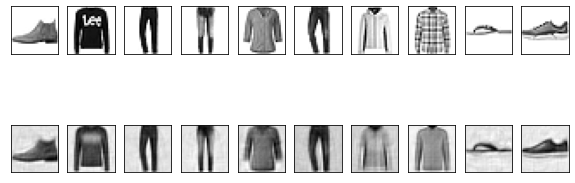

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.008508
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.008750
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.009215
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.010215
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.010751
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.010394
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.010768
Train Epoch: 2 [44800/60000 (75%)]	Train Loss: 0.009258
Train Epoch: 2 [51200/60000 (85%)]	Train Loss: 0.009429
Train Epoch: 2 [57600/60000 (96%)]	Train Loss: 0.008032

[EPOCH: 2], 	Test Loss: 0.0003


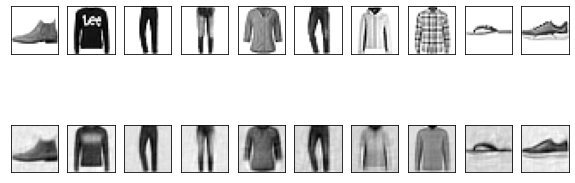

Train Epoch: 3 [0/60000 (0%)]	Train Loss: 0.008629
Train Epoch: 3 [6400/60000 (11%)]	Train Loss: 0.008566
Train Epoch: 3 [12800/60000 (21%)]	Train Loss: 0.010871
Train Epoch: 3 [19200/60000 (32%)]	Train Loss: 0.010906
Train Epoch: 3 [25600/60000 (43%)]	Train Loss: 0.010108
Train Epoch: 3 [32000/60000 (53%)]	Train Loss: 0.010128
Train Epoch: 3 [38400/60000 (64%)]	Train Loss: 0.011196
Train Epoch: 3 [44800/60000 (75%)]	Train Loss: 0.009739
Train Epoch: 3 [51200/60000 (85%)]	Train Loss: 0.010786
Train Epoch: 3 [57600/60000 (96%)]	Train Loss: 0.007366

[EPOCH: 3], 	Test Loss: 0.0003


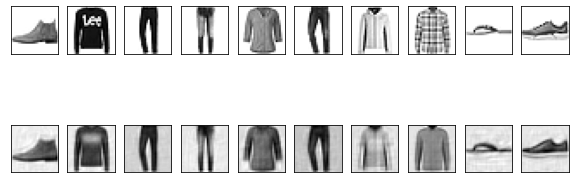

Train Epoch: 4 [0/60000 (0%)]	Train Loss: 0.010953
Train Epoch: 4 [6400/60000 (11%)]	Train Loss: 0.010316
Train Epoch: 4 [12800/60000 (21%)]	Train Loss: 0.009930
Train Epoch: 4 [19200/60000 (32%)]	Train Loss: 0.008841
Train Epoch: 4 [25600/60000 (43%)]	Train Loss: 0.010247
Train Epoch: 4 [32000/60000 (53%)]	Train Loss: 0.008910
Train Epoch: 4 [38400/60000 (64%)]	Train Loss: 0.008241
Train Epoch: 4 [44800/60000 (75%)]	Train Loss: 0.008115
Train Epoch: 4 [51200/60000 (85%)]	Train Loss: 0.012435
Train Epoch: 4 [57600/60000 (96%)]	Train Loss: 0.009717

[EPOCH: 4], 	Test Loss: 0.0003


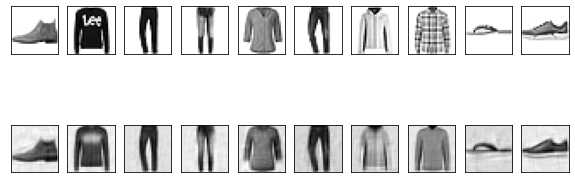

Train Epoch: 5 [0/60000 (0%)]	Train Loss: 0.008241
Train Epoch: 5 [6400/60000 (11%)]	Train Loss: 0.009004
Train Epoch: 5 [12800/60000 (21%)]	Train Loss: 0.008930
Train Epoch: 5 [19200/60000 (32%)]	Train Loss: 0.008356
Train Epoch: 5 [25600/60000 (43%)]	Train Loss: 0.010989
Train Epoch: 5 [32000/60000 (53%)]	Train Loss: 0.009455
Train Epoch: 5 [38400/60000 (64%)]	Train Loss: 0.012893
Train Epoch: 5 [44800/60000 (75%)]	Train Loss: 0.010381
Train Epoch: 5 [51200/60000 (85%)]	Train Loss: 0.010677
Train Epoch: 5 [57600/60000 (96%)]	Train Loss: 0.010641

[EPOCH: 5], 	Test Loss: 0.0003


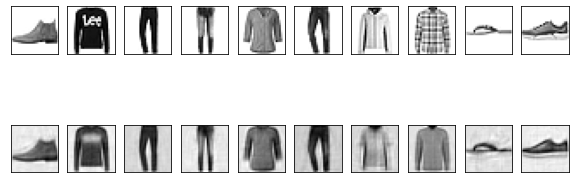

Train Epoch: 6 [0/60000 (0%)]	Train Loss: 0.008048
Train Epoch: 6 [6400/60000 (11%)]	Train Loss: 0.010366
Train Epoch: 6 [12800/60000 (21%)]	Train Loss: 0.008487
Train Epoch: 6 [19200/60000 (32%)]	Train Loss: 0.008846
Train Epoch: 6 [25600/60000 (43%)]	Train Loss: 0.010176
Train Epoch: 6 [32000/60000 (53%)]	Train Loss: 0.009878
Train Epoch: 6 [38400/60000 (64%)]	Train Loss: 0.009689
Train Epoch: 6 [44800/60000 (75%)]	Train Loss: 0.007767
Train Epoch: 6 [51200/60000 (85%)]	Train Loss: 0.009198
Train Epoch: 6 [57600/60000 (96%)]	Train Loss: 0.009130

[EPOCH: 6], 	Test Loss: 0.0003


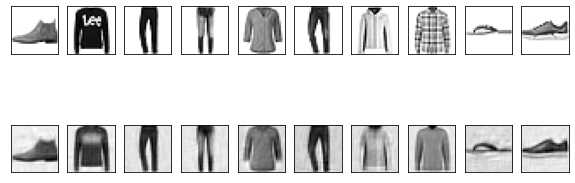

Train Epoch: 7 [0/60000 (0%)]	Train Loss: 0.012383
Train Epoch: 7 [6400/60000 (11%)]	Train Loss: 0.008682
Train Epoch: 7 [12800/60000 (21%)]	Train Loss: 0.009619
Train Epoch: 7 [19200/60000 (32%)]	Train Loss: 0.008496
Train Epoch: 7 [25600/60000 (43%)]	Train Loss: 0.009256
Train Epoch: 7 [32000/60000 (53%)]	Train Loss: 0.008202
Train Epoch: 7 [38400/60000 (64%)]	Train Loss: 0.011872
Train Epoch: 7 [44800/60000 (75%)]	Train Loss: 0.009011
Train Epoch: 7 [51200/60000 (85%)]	Train Loss: 0.009476
Train Epoch: 7 [57600/60000 (96%)]	Train Loss: 0.009164

[EPOCH: 7], 	Test Loss: 0.0003


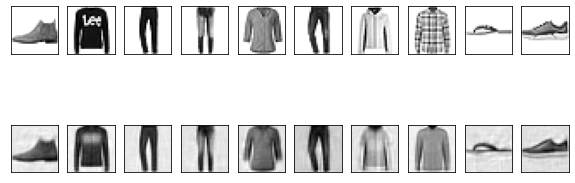

Train Epoch: 8 [0/60000 (0%)]	Train Loss: 0.010952
Train Epoch: 8 [6400/60000 (11%)]	Train Loss: 0.010857
Train Epoch: 8 [12800/60000 (21%)]	Train Loss: 0.010913
Train Epoch: 8 [19200/60000 (32%)]	Train Loss: 0.009702
Train Epoch: 8 [25600/60000 (43%)]	Train Loss: 0.010273
Train Epoch: 8 [32000/60000 (53%)]	Train Loss: 0.009197
Train Epoch: 8 [38400/60000 (64%)]	Train Loss: 0.010148
Train Epoch: 8 [44800/60000 (75%)]	Train Loss: 0.007117
Train Epoch: 8 [51200/60000 (85%)]	Train Loss: 0.009851
Train Epoch: 8 [57600/60000 (96%)]	Train Loss: 0.010794

[EPOCH: 8], 	Test Loss: 0.0003


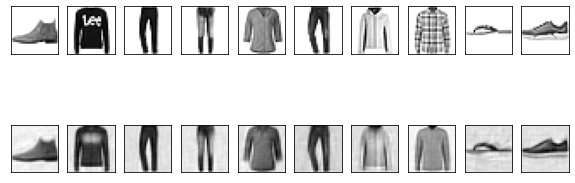

Train Epoch: 9 [0/60000 (0%)]	Train Loss: 0.008330
Train Epoch: 9 [6400/60000 (11%)]	Train Loss: 0.009389
Train Epoch: 9 [12800/60000 (21%)]	Train Loss: 0.011645
Train Epoch: 9 [19200/60000 (32%)]	Train Loss: 0.008186
Train Epoch: 9 [25600/60000 (43%)]	Train Loss: 0.008068
Train Epoch: 9 [32000/60000 (53%)]	Train Loss: 0.010474
Train Epoch: 9 [38400/60000 (64%)]	Train Loss: 0.010244
Train Epoch: 9 [44800/60000 (75%)]	Train Loss: 0.008824
Train Epoch: 9 [51200/60000 (85%)]	Train Loss: 0.009163
Train Epoch: 9 [57600/60000 (96%)]	Train Loss: 0.008396

[EPOCH: 9], 	Test Loss: 0.0003


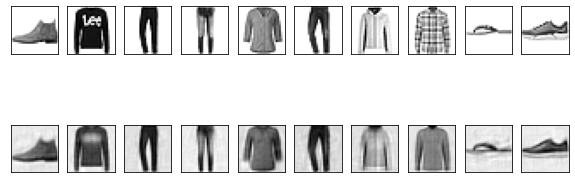

Train Epoch: 10 [0/60000 (0%)]	Train Loss: 0.009393
Train Epoch: 10 [6400/60000 (11%)]	Train Loss: 0.006764
Train Epoch: 10 [12800/60000 (21%)]	Train Loss: 0.007762
Train Epoch: 10 [19200/60000 (32%)]	Train Loss: 0.007963
Train Epoch: 10 [25600/60000 (43%)]	Train Loss: 0.007861
Train Epoch: 10 [32000/60000 (53%)]	Train Loss: 0.007330
Train Epoch: 10 [38400/60000 (64%)]	Train Loss: 0.008182
Train Epoch: 10 [44800/60000 (75%)]	Train Loss: 0.008567
Train Epoch: 10 [51200/60000 (85%)]	Train Loss: 0.008537
Train Epoch: 10 [57600/60000 (96%)]	Train Loss: 0.009246

[EPOCH: 10], 	Test Loss: 0.0003


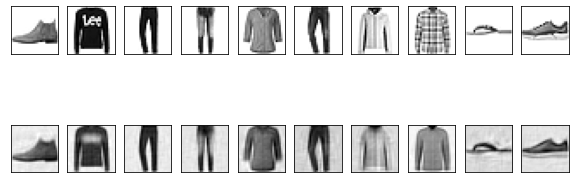

In [23]:
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, real_image, gen_image = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(Epoch, test_loss))

  f, a = plt.subplots(2, 10, figsize = (10, 4))
  for i in range(10):
    img = np.reshape(real_image[0][i], (28, 28))
    a[0][i].imshow(img, cmap= "gray_r")
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())

  for i in range(10):
    img = np.reshape(gen_image[0][i], (28, 28))
    a[1][i].imshow(img, cmap= "gray_r")
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())
  
  plt.show()